In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
vectors = pd.read_feather('data/1m.ftr')
corr = vectors.corr()
vectors.shape

(473641, 40)

In [51]:
vectors.iloc[:5, :5]

,Special Gasoline,Special Diesel,Lubricant,Diesel Auto Clean,Gasoline
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,0,1,1,0
4,1,0,0,0,0


### Plot Correlation Matrix 

In [56]:
def triangle_map(corrmat):
    fig, ax = plt.subplots(figsize=(12,12))
    df_lt = corrmat.where(np.tril(np.ones(corrmat.shape)).astype(np.bool))
    sns.heatmap(df_lt, cmap='binary', square=True, linewidths=0.2)
    plt.show()

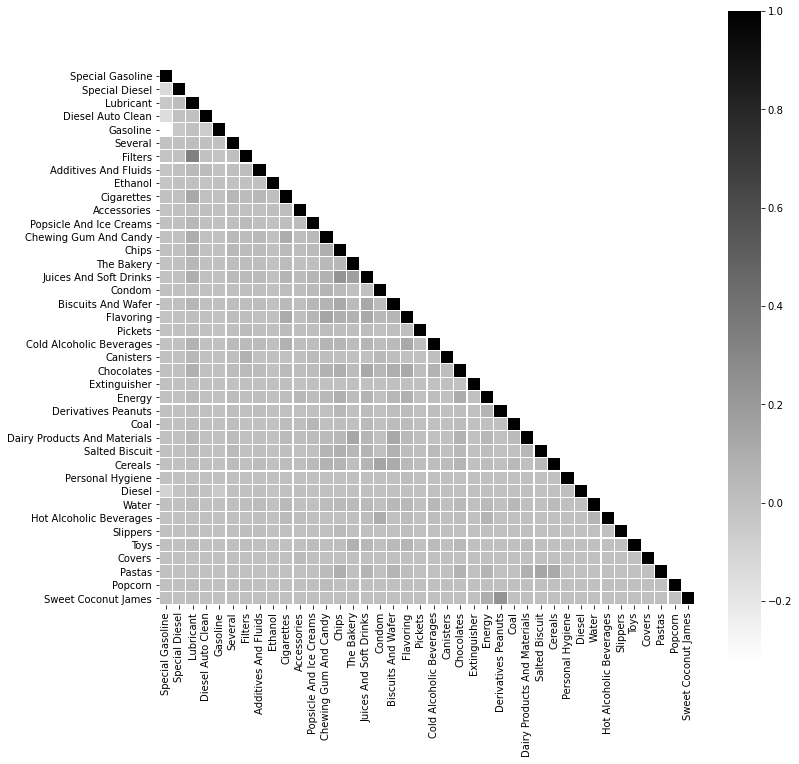

In [57]:
triangle_map(corr)

### Make Graph

In [5]:
# Vectorized distance function to transform matrix
def dfunc(cell):
        return np.sqrt(2 * (1 - cell))

In [13]:
# Generates an encoded dictionary mapping each 
# node to an encoded value for each product
def make_labels(vec_df, limit=None):
    # Get columns and restrict if specified
    cols = vec_df.columns
    cols = cols[:limit] if limit else cols
    
    # Encode each label
    le = LabelEncoder()
    encoded = le.fit_transform(cols)
    
    # Generate a dict mapping each node to a label
    labels = {i:encoded[i] for i in range(len(cols))}
    
    # Make a legend for products and encodings
    legend = list(zip(encoded, vectors.columns))
    # Sort the legend for ease of use
    legend.sort()
    legend = dict(legend)
    
    # Generate a dict mapping each node to a label
#     labels = {}
#     for i in range(len(cols)):
#         labels[i] = encoded[i]
    
    return labels, legend

In [14]:
# Draw a graph with the specified parameters
def draw(G, pos, ax, node_color='c', node_size=400, width=1, edge_color='0.25', font_size=15):
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_color, node_size=node_size)
    nx.draw_networkx_edges(G, pos, ax=ax, width=width, edge_color=edge_color)
    nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=font_size)

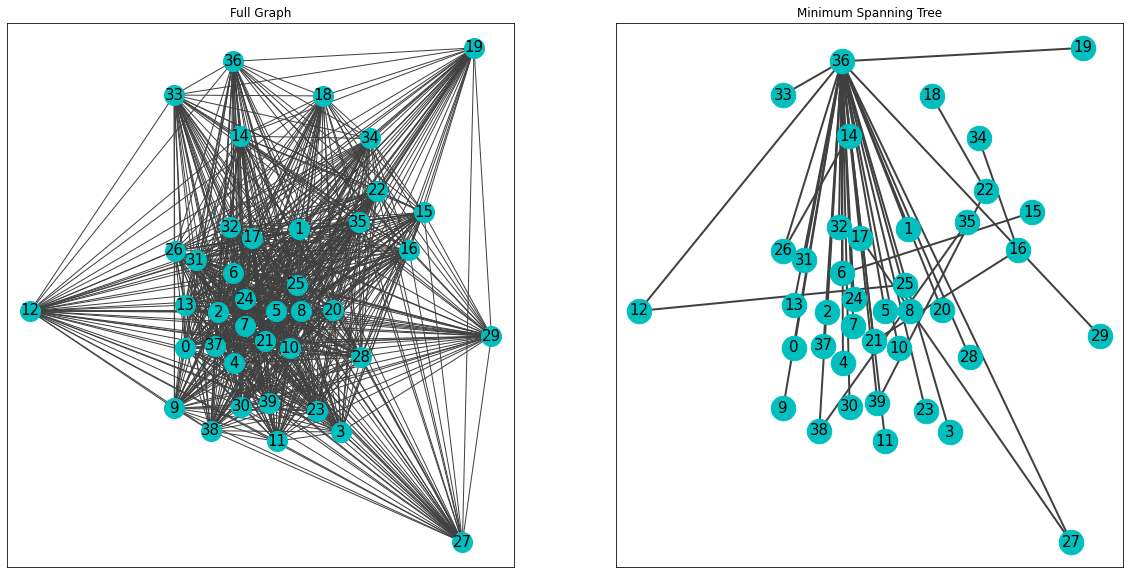

{0: 'Accessories',
 1: 'Additives And Fluids',
 2: 'Biscuits And Wafer',
 3: 'Canisters',
 4: 'Cereals',
 5: 'Chewing Gum And Candy',
 6: 'Chips',
 7: 'Chocolates',
 8: 'Cigarettes',
 9: 'Coal',
 10: 'Cold Alcoholic Beverages',
 11: 'Condom',
 12: 'Covers',
 13: 'Dairy Products And Materials',
 14: 'Derivatives Peanuts',
 15: 'Diesel',
 16: 'Diesel Auto Clean',
 17: 'Energy',
 18: 'Ethanol',
 19: 'Extinguisher',
 20: 'Filters',
 21: 'Flavoring',
 22: 'Gasoline',
 23: 'Hot Alcoholic Beverages',
 24: 'Juices And Soft Drinks',
 25: 'Lubricant',
 26: 'Pastas',
 27: 'Personal Hygiene',
 28: 'Pickets',
 29: 'Popcorn',
 30: 'Popsicle And Ice Creams',
 31: 'Salted Biscuit',
 32: 'Several',
 33: 'Slippers',
 34: 'Special Diesel',
 35: 'Special Gasoline',
 36: 'Sweet Coconut James',
 37: 'The Bakery',
 38: 'Toys',
 39: 'Water'}

In [65]:
# Global variables
limit = None
labels, legend = make_labels(vectors, limit=limit)
use_distance = False
# Make graphs 
corrmat = np.array(vectors.corr())
corrmat = np.absolute(corrmat)
corrmat = dfunc(corrmat) if use_distance else corrmat
corrmat = corrmat[:limit, :limit] if limit else corrmat
G = nx.from_numpy_matrix(corrmat) # Graph
MST = nx.minimum_spanning_tree(G) # Minimum Spanning Tree

# Uniform layout for all plots to follow
pos = nx.spring_layout(G)

# Axes to draw on
nrows, ncols = 1,2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

# Draw full graph
draw(G, pos, ax[0])
ax[0].set_title('Full Graph')

# Draw MST
draw(MST, pos, ax[1], node_size=600, width=2)
ax[1].set_title('Minimum Spanning Tree')

# Show
plt.show()

# Use to map numbers to products
legend

In [71]:
# Sort the edges by shortest values (i.e. closest relations)
E = [(a,b,c['weight']) for (a,b,c) in MST.edges(data=True)]
E = sorted(E, key=lambda x: x[2], reverse=False)

In [72]:
for edge in E:
    print(f'{legend[edge[0]]} -> {legend[edge[1]]}: {edge[2]:.8f}')

The Bakery -> Water: 0.00000299
Popsicle And Ice Creams -> Water: 0.00000299
Special Diesel -> Water: 0.00000366
Sweet Coconut James -> Water: 0.00000366
Toys -> Water: 0.00000366
Slippers -> Water: 0.00000597
Diesel Auto Clean -> Water: 0.00000731
Pastas -> Water: 0.00000871
Pickets -> Water: 0.00001077
Special Gasoline -> Water: 0.00001117
Several -> Water: 0.00001231
Lubricant -> The Bakery: 0.00001267
Popcorn -> Water: 0.00001267
Flavoring -> Water: 0.00001622
Hot Alcoholic Beverages -> Water: 0.00001702
Personal Hygiene -> Water: 0.00001767
Condom -> Water: 0.00002122
Derivatives Peanuts -> Water: 0.00002507
Energy -> Water: 0.00002534
Canisters -> Ethanol: 0.00003048
Juices And Soft Drinks -> Popsicle And Ice Creams: 0.00003188
Dairy Products And Materials -> Water: 0.00003399
Filters -> Water: 0.00003951
Gasoline -> Water: 0.00004182
Cold Alcoholic Beverages -> Water: 0.00004256
Diesel -> Water: 0.00004560
Chewing Gum And Candy -> Water: 0.00004618
Covers -> Water: 0.00004995
Co

In [49]:
r = np.arange(-1, 1, 0.1)
[round(x, 2) for x in r]

[-1.0,
 -0.9,
 -0.8,
 -0.7,
 -0.6,
 -0.5,
 -0.4,
 -0.3,
 -0.2,
 -0.1,
 -0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9]

In [50]:
dfunc(r)

array([2.        , 1.94935887, 1.8973666 , 1.84390889, 1.78885438,
       1.73205081, 1.67332005, 1.61245155, 1.54919334, 1.4832397 ,
       1.41421356, 1.34164079, 1.26491106, 1.18321596, 1.09544512,
       1.        , 0.89442719, 0.77459667, 0.63245553, 0.4472136 ])